In [ ]:
###To better understand this workbook, I'm adding notations everywhere.
###I'm using triple-# to distinguish my annotations from preexisting comments.  -Tristan

In [1]:
###Import packages
import datetime
import matplotlib as mp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

###set graph settings
sns.set()
sns.set_style('whitegrid')
sns.set_style('ticks')

In [2]:
###a suffix appended to the output to prevent overwriting past results
save_suffix = '2019-02-06'

# data

In [3]:
# https://data.sfgov.org/Housing-and-Buildings/Planning-Department-Records/7yuw-98m5
# csv: https://data.sfgov.org/api/views/kgai-svwy/rows.csv?accessType=DOWNLOAD
# glossary: http://default.sfplanning.org/GIS/DataSF_PPTS_Fields.xlsx

###The data is under gitignore, so it must be unzipped in the local branch
###I think compress.sh and decompress.sh are used to unzip, but I couldn't figure out how to use those, so I just use tar
###In bash, execute "cat PPTS_Records_data.tgz_a* | tar xzv"

fields = pd.read_csv('planning-department-records-2018/DataSF_PPTS_Fields.csv')
data = pd.read_csv('planning-department-records-2018/PPTS_Records_data.csv',
                   parse_dates=[
                       'date_opened',
                       'date_closed',
                   ],
                   infer_datetime_format=True)

C:\Users\Tristan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (28,31,32,33,34,36,38,39,40,41,42,43,44,45,46,48,119,163,167,168,169) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# prj is a decent first-approximation of the first time planning learns about a project
prj = data[data['record_type_category'] == 'PRJ']

###This code is clearly taking a subset of the data, although I don't yet understand what it is.
###The entire data set is 190k rows, and the subset is 40k rows.

In [5]:
# Find all projects with any units proposed
market_res_units = [
    'PRJ_FEATURE_MARKET_RATE_EXIST',
    'PRJ_FEATURE_MARKET_RATE_PROP',
    'PRJ_FEATURE_MARKET_RATE_NET',
]
aff_res_units = [
    'PRJ_FEATURE_AFFORDABLE_EXIST',
    'PRJ_FEATURE_AFFORDABLE_PROP',
    'PRJ_FEATURE_AFFORDABLE_NET',
]

res_units = market_res_units + aff_res_units

q = ~pd.isna(prj[res_units[0]])
for r in res_units[1:]:
    q |= ~pd.isna(prj[r])
prj_res = prj[q]

###This code takes the subset of rows that have data in at least one of the 6 named columns
###The six columns describe the number of market rate or affordable units before and after the proposed project, and the change.
###I'm guessing if all of these columns are nans, then it's not a housing project at all
###4k rows remain.

In [6]:
# Unfortunately, planning is missing data for anything before 2014 Q4
#prj_res = prj_res[prj_res.date_opened >= datetime.datetime(2014,10,1)]
# This data was fetched on 2018-11-15, so exclude 2018Q4 because it's incomplete
#prj_res = prj_res[prj_res.date_opened < datetime.datetime(2018,9,30)]

###The above code would not run, because python doesn't like to compare times with and without timestamps.  Here's the fix:
prj_res = prj_res[prj_res.date_opened >= pd.Timestamp(datetime.datetime(2014,10,1),tz='UTC')]
prj_res = prj_res[prj_res.date_opened < pd.Timestamp(datetime.datetime(2018,9,30),tz='UTC')]
###I could probably fetch new data for 2018Q4, but not right now.

In [7]:
len(prj_res)

4067

In [8]:
def quarter(dt):
    return "%s Q%s" % (dt.year, int(np.ceil((dt.month)/3)))


def half(dt):
    return "%s H%s" % (dt.year, int(np.ceil((dt.month)/6)))


def monthyear(dt):
    return "%s %s" % (dt.year, dt.strftime("%b"))

prj_res['_year'] = prj_res['date_opened'].apply(lambda dt: str(dt.year))
prj_res['_quarter'] = prj_res['date_opened'].apply(quarter)
prj_res['_half'] = prj_res['date_opened'].apply(half)
prj_res['_month'] = prj_res['date_opened'].apply(monthyear)

###Creates new columns categorizing data by year, quarter, half-year, and month

# Analysis

In [9]:
len(data[data.date_opened.dt.year == 2017])
###This is the number of rows in the full data set that were opened in 2017

14729

In [10]:
for year in range(2010, 2019):
    print("%s: %s" % (year, data[data.date_opened.dt.year == year][['PRJ_FEATURE_AFFORDABLE_PROP', 'PRJ_FEATURE_MARKET_RATE_PROP']].sum().sum()))
    
###This sums up the total number of housing units proposed in each year

2010: 0.0
2011: 0.0
2012: 0.0
2013: 4.0
2014: 3225.0
2015: 14689.0
2016: 9555.0
2017: 9674.0
2018: 7701.0


In [11]:
#before = prj_res[prj_res.date_opened < datetime.datetime(2016,7,1)]  # Before Prop C
#after = prj_res[prj_res.date_opened >= datetime.datetime(2016,7,1)]  # After Prop C

###Steven seems particularly interested in seeing whether the housing projects were affected by Prop C, which apparently went into effect in July 2016.
###I had to modify this code, because it doesn't run for me
before = prj_res[prj_res.date_opened < pd.Timestamp(datetime.datetime(2016,7,1),tz='UTC')]  # Before Prop C
after = prj_res[prj_res.date_opened >= pd.Timestamp(datetime.datetime(2016,7,1),tz='UTC')]  # After Prop C

## All projects with some market-rate units

In [25]:
### mrk_data is the net change in market rate units proposed each quarter
mrk_data = prj_res.groupby('_quarter').aggregate({'PRJ_FEATURE_MARKET_RATE_NET': 'sum'})
### fit mrk_data to a line
d = mrk_data.PRJ_FEATURE_MARKET_RATE_NET.values.tolist()
params = np.polyfit(range(len(d)), d, 1)
poly = np.poly1d(params)

### Now just look at the quarters before and after prop C, and calculate the average per quarter
mrk_data_before = before.groupby('_quarter').aggregate({'PRJ_FEATURE_MARKET_RATE_NET': 'sum'})
d = mrk_data_before.PRJ_FEATURE_MARKET_RATE_NET.values.tolist()
offset = len(d)
avg_before = np.mean(d)

mrk_data_after = after.groupby('_quarter').aggregate({'PRJ_FEATURE_MARKET_RATE_NET': 'sum'})
d = mrk_data_after.PRJ_FEATURE_MARKET_RATE_NET.values.tolist()
avg_after = np.mean(d)

### Code for plot creation
f = mp.pyplot.figure()
ax = f.gca()
p = mrk_data.plot.bar(ax=ax)
p.set_label("_nolegend_")

xp = np.linspace(0, len(mrk_data.PRJ_FEATURE_MARKET_RATE_NET.values), 20)
l1 = ax.plot(xp, poly(xp), label='trend', color='red')
l2 = ax.hlines(avg_before, 0, offset, label='avg before', linestyles='dashed')
l3 = ax.hlines(avg_after, offset, len(d) + offset, label='avg after', linestyles='dotted')
mp.pyplot.title("Market Rate Units Proposed (net)")
ax.set_ylabel("# Housing units")
ax.set_xlabel("Filing year")
#ax.legend()
ax.legend((l1[0], l2, l3), ('trend', 'avg before prop C', 'avg after prop C'))
sns.despine()
f.set_dpi(100)
f.savefig("figs/market-rate-net-%s.png" % save_suffix, dpi=300, bbox_inches='tight')

## All Affordable units

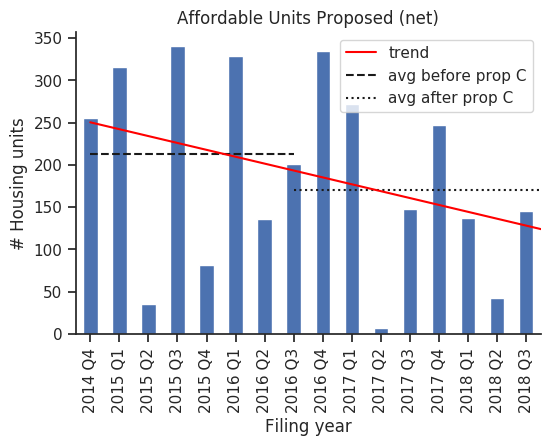

In [14]:
### Repeat above code, now looking at affordable units
aff_data = prj_res.groupby('_quarter').aggregate({'PRJ_FEATURE_AFFORDABLE_NET': 'sum'})
d = aff_data.PRJ_FEATURE_AFFORDABLE_NET.values.tolist()
params = np.polyfit(range(len(d)), d, 1)
poly = np.poly1d(params)

aff_data_before = before.groupby('_quarter').aggregate({'PRJ_FEATURE_AFFORDABLE_NET': 'sum'})
d = aff_data_before.PRJ_FEATURE_AFFORDABLE_NET.values.tolist()
offset = len(d)
avg_before = np.mean(d)

aff_data_after = after.groupby('_quarter').aggregate({'PRJ_FEATURE_AFFORDABLE_NET': 'sum'})
d = aff_data_after.PRJ_FEATURE_AFFORDABLE_NET.values.tolist()
avg_after = np.mean(d)

f = mp.pyplot.figure()
ax = f.gca()
p = aff_data.plot.bar(ax=ax)
p.set_label("_nolegend_")

xp = np.linspace(0, len(aff_data.PRJ_FEATURE_AFFORDABLE_NET.values), 20)
l1 = ax.plot(xp, poly(xp), label='trend', color='red')
l2 = ax.hlines(avg_before, 0, offset, label='avg before', linestyles='dashed')
l3 = ax.hlines(avg_after, offset, len(d) + offset, label='avg after', linestyles='dotted')
mp.pyplot.title("Affordable Units Proposed (net)")
ax.set_ylabel("# Housing units")
ax.set_xlabel("Filing year")
#ax.legend()
ax.legend((l1[0], l2, l3), ('trend', 'avg before prop C', 'avg after prop C'))
sns.despine()

f.set_dpi(100)
f.savefig("figs/affordable-net-%s.png" % save_suffix, dpi=300, bbox_inches='tight')

## Break down by project type

The percentage of subsidized affordable units mandated by law varies according to the size of the project:

* Fewer than 10 units: 0%
* Fewer than 25 units: 12%
* 25 or more units: 20%

The old requirement was a flat 12% on projects with more than 10 units, so we can compare the classes of projects to get an estimate for the impact of Prop C.

In [15]:
###This creates a new column to classify the size of the project
def project_type(mrk_units):
    if not mrk_units:
        return "NA"
    if int(mrk_units) < 10:
        return "0"
    elif int(mrk_units) < 25:
        return "12"
    else:
        return "18-20"
    
prj_res['_project_type'] = prj_res[prj_res['PRJ_FEATURE_MARKET_RATE_NET']>0]['PRJ_FEATURE_MARKET_RATE_NET'].apply(project_type)

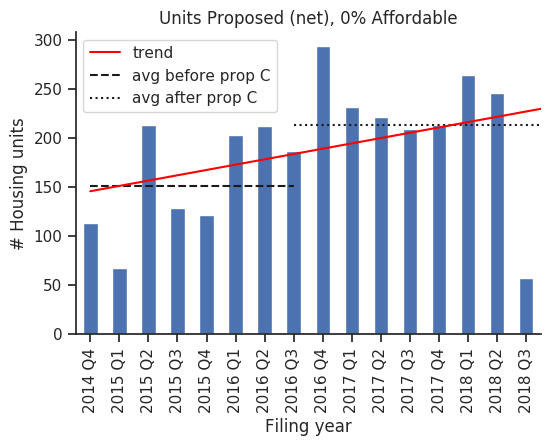

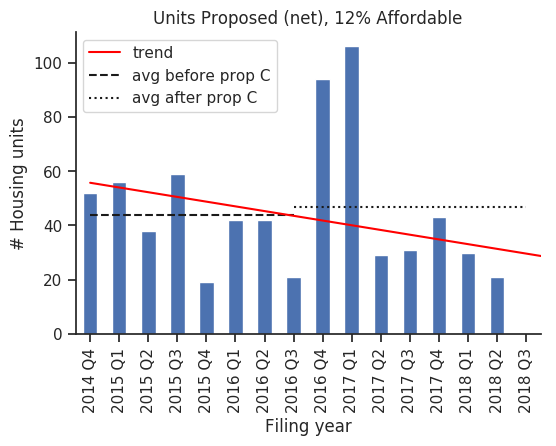

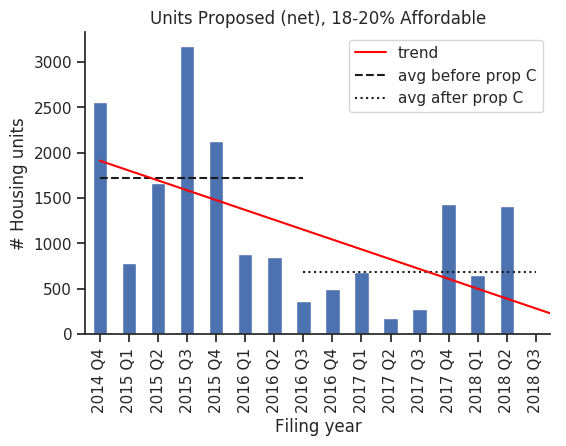

In [16]:
before = prj_res[prj_res.date_opened < datetime.datetime(2016,7,1)]  # Before Prop C
after = prj_res[prj_res.date_opened >= datetime.datetime(2016,7,1)]  # After Prop C

### mrk_data is the total market rate units proposed, grouped by quarter and project type
### Essentially this is showing that the number of projects with 25+ proposed new units decreased after prop C because
### apparently prop C required that these projects have a higher percentage of affordable housing units
mrk_data = prj_res.groupby(['_quarter', '_project_type']).aggregate({'PRJ_FEATURE_MARKET_RATE_NET': 'sum'})
# 2018Q3 has no projects in the 12 and 18-20 buckets, so they're missing from the groupby/aggregate, so add them in
mrk_data.loc[('2018 Q3', '12'), 'PRJ_FEATURE_MARKET_RATE_NET'] = 0
mrk_data.loc[('2018 Q3', '18-20'), 'PRJ_FEATURE_MARKET_RATE_NET'] = 0
mrk_data_before = before.groupby(['_quarter', '_project_type']).aggregate({'PRJ_FEATURE_MARKET_RATE_NET': 'sum'})
mrk_data_after = after.groupby(['_quarter', '_project_type']).aggregate({'PRJ_FEATURE_MARKET_RATE_NET': 'sum'})

idx = pd.IndexSlice
for c, _project_type in enumerate(['0', '12', '18-20']):
    _mrk = mrk_data.loc[idx[:, _project_type], idx[:]]
    # Clean up indices for plotting
    _mrk = _mrk.reset_index().set_index('_quarter').drop(columns=['_project_type'])
    _mrk_before = mrk_data_before.loc[idx[:, _project_type], idx[:]]
    _mrk_after = mrk_data_after.loc[idx[:, _project_type], idx[:]]
    
    d = _mrk.PRJ_FEATURE_MARKET_RATE_NET.values.tolist()
    params = np.polyfit(range(len(d)), d, 1)
    poly = np.poly1d(params)

    d = _mrk_before.PRJ_FEATURE_MARKET_RATE_NET.values.tolist()
    offset = len(d)
    avg_before = np.mean(d)

    d = _mrk_after.PRJ_FEATURE_MARKET_RATE_NET.values.tolist()
    avg_after = np.mean(d)
    f = mp.pyplot.figure()
    ax = f.gca()
    #ax = axarr[c]
    #p = _mrk.plot.bar(x=_mrk.index.levels[0], ax=ax)
    p = _mrk.plot.bar(ax=ax)
    #p.set_label("_nolegend_")

    xp = np.linspace(0, len(_mrk.PRJ_FEATURE_MARKET_RATE_NET.values), 20)
    l1 = ax.plot(xp, poly(xp), label='trend', color='red')
    l2 = ax.hlines(avg_before, 0, offset, label='avg before', linestyles='dashed')
    l3 = ax.hlines(avg_after, offset, len(d) + offset, label='avg after', linestyles='dotted')
    ax.set_xlabel("%s%% Affordable" % _project_type)

    #ax.legend()
    mp.pyplot.title("Units Proposed (net), %s%% Affordable" % _project_type)
    ax.set_ylabel("# Housing units")
    ax.set_xlabel("Filing year")
    #ax.legend()
    ax.legend((l1[0], l2, l3), ('trend', 'avg before prop C', 'avg after prop C'))
    sns.despine()
    f.set_dpi(100)
    if c == 0:
        ax.legend((l1[0], l2, l3), ('trend', 'avg before prop C', 'avg after prop C'))
    sns.despine()
    f.set_dpi(100)
    f.savefig("figs/market-rate-net-%s-affordable-%s.png" % (_project_type, save_suffix), dpi=100, bbox_inches='tight')